# Introduction

In this Homework, we will be developing a solver that solves the Burger's equation, see inviscid form below.

$$ \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}=0 $$

This form can also be re-written in flux form below, also in inviscid form.

$$ \frac{\partial u}{\partial t}+\frac{1}{2}\frac{\partial u^{2}}{\partial x}=0 $$


In [1]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt

# Add the directory containing your module to sys.path
module_path = os.path.abspath(os.path.join('..', r"A:\Users\mtthl\Documents\Education\ME5653_CFD\git\me5653_CFD_repo\code\lib" ))
sys.path.append(module_path)

from distributedObjects import *
from distributedFunctions import *


# Part (1)

The first part is to solve the Burger's equation using Lax method. The fundamental transformation that we need to understand to facilitate this method is that the term $\frac{u^{2}}{2}$ is substituted by $v$. Thus, the Burger's equation takes the form of:

$$ \frac{\partial u}{\partial t}+\frac{\partial v}{\partial x}=0 $$

It is worth noting that $ \underline{\text{Computational Fluid Mechanics and Heat Transfer}} $ by Anderson et al. $^{[1]}$ use $F$ instead of $v$, so those two notations may be used interchangeably.

Lax method in 1D takes 3x points for a stencil for the time gradient


In [2]:
lax_tg_gradient = numericalGradient( 1 , ( 1 , 0 ) )
print( "The coefficients for the time gradient are:\t" + str( lax_tg_gradient.coeffs ) )


 
 
 
 
 
 
The coefficients for the time gradient are:	[-1.  1.]


However, there is a slight modification in the method for the time gradient, which is that the previous time step is represented by the average of the two surrounding points. ie:

$$ \frac{\partial u}{\partial t} = \frac{u^{n+1}_{i}- \left( \frac{u^{n}_{i+1}+u^{n}_{i-1}}{2} \right)}{\Delta t} $$


Now, the spatial gradient is requested to be 6th order for the interior points, and 5th order for the boundary points.

Thus, the interior points can be calculated.


In [3]:
lax_sg_gradient = numericalGradient( 1 , ( 3 , 3 ) )
print( "The coefficient for the interior spatial gradient are:\n\t" + str( lax_sg_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficient for the interior spatial gradient are:
	[-1.66666667e-02  1.50000000e-01 -7.50000000e-01  3.70074342e-16
  7.50000000e-01 -1.50000000e-01  1.66666667e-02]


And the boundary points.


In [4]:
lax_sg_LHS_gradient = numericalGradient( 1 , ( 0 , 5 ) )
print( "The coefficients for the LHS boundary spatial gradient are:\n\t" + str( lax_sg_LHS_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficients for the LHS boundary spatial gradient are:
	[-2.28333333  5.         -5.          3.33333333 -1.25        0.2       ]


In [5]:
lax_sg_RHS_gradient = numericalGradient( 1 , ( 5 , 0 ) )
print( "The coefficients for the RHS boundary spatial gradient are:\n\t" + str( lax_sg_RHS_gradient.coeffs ) )


 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
The coefficients for the RHS boundary spatial gradient are:
	[-0.2         1.25       -3.33333333  5.         -5.          2.28333333]


Thus, from these results, the spatial gradients become

$ \underline{\text{Interior Points}} $:

$$ \frac{\partial v}{\partial t}= \frac{-\frac{1}{60} v_{i-3}+\frac{3}{20} v_{i-2}-\frac{3}{4} v_{i-1}+\frac{3}{4} v_{i+1}-\frac{3}{20} v_{i+2}+\frac{1}{60} v_{i+3}}{\Delta x}$$

$ \underline{\text{LHS points}} $:

$$ \frac{\partial v}{\partial t}= \frac{-\frac{137}{60} v_{i}+5 v_{i+1}-5 v_{i+2}+\frac{10}{3} v_{i+3}-\frac{5}{4} v_{i+4}+\frac{1}{5} v_{i+5}}{\Delta x} $$

$ \underline{\text{RHS points}} $:

$$ \frac{\partial v}{\partial t}= \frac{\frac{137}{60} v_{i}-5 v_{i-1}+5 v_{i-2}-\frac{10}{3} v_{i-3}+\frac{5}{4} v_{i-4}-\frac{1}{5} v_{i-5}}{\Delta x} $$


Re-arranging all these equations to get the unknowns on the left side and the knowns from the previous time step on the right side, we get for the interior points:

$$ u^{n+1}_{i}=\frac{1}{2}\left(u^{n}_{i-1}+u^{n}_{i+1}\right)+\left(\frac{\Delta t}{\Delta x}\right)\left( -\frac{1}{60}v_{i-3}+\frac{3}{20}v_{i-2}-\frac{3}{4}v_{i-1}+\frac{3}{4}v_{i+1}-\frac{3}{20}v_{i+2}+\frac{1}{60}v_{i+3} \right) $$



This forms the following linear equation:

$$ [1][u_{i}]^{n+1}= \frac{1}{2}\begin{bmatrix} 1 & 0 & 1 \end{bmatrix} \begin{bmatrix} u_{i-1} & u_{i} & u_{i+1} \end{bmatrix}^{T, n} + C \begin{bmatrix} -\frac{1}{60} & \frac{3}{20} & -\frac{3}{4} & 0 & \frac{3}{4} & -\frac{3}{20} & \frac{1}{60} \end{bmatrix} \begin{bmatrix} v_{i-3} & v_{i-2} & v_{i-1} & v_{i} & v_{i+1} & v_{i+2} & v_{i+3} \end{bmatrix}^{T , n}  $$

Where $C=\left(\frac{\Delta t}{\Delta x}\right) $, where $ CFL=Cu $



To use this solver, we will first use an example problem of the following characteristic function:

$$ u(x,t)=-U tanh(k(x-ut)) $$

In this case, $x\in(0,1)$, $k=1$, and since the domain of $t$ is not defined, $t\in(0,1)$. There will be 1,000 x and t samples.


In [6]:
N_x = int(20)
N_t = int(20)
x_domain = np.linspace( 0 , 1 , num=N_x )
t_domain = np.linspace( 0 , 1 , num=N_t )
k = 1


And from this, we can set the characteristic function to be essentially non-dimensional to its maximum initial value by setting $U=1$.


In [7]:
U = 1


Thus, the exact solution becomes:


In [8]:
u_exact = np.zeros( ( len(x_domain) , len(t_domain) ) )

for i , t in enumerate( t_domain ):
    if i>0:
        u_exact[:,i] = - U * np.tanh( k * ( x_domain - u_exact[:,i-1] * t ) )
    else:
        u_exact[:,i] = - U * np.tanh( k * x_domain )


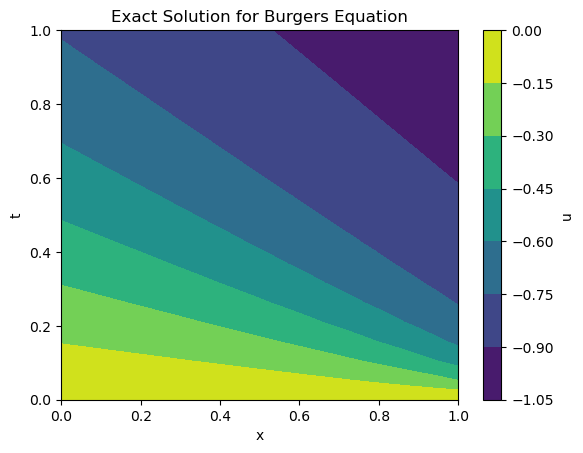

In [9]:
x = x_domain
y = t_domain
X , Y = np.meshgrid( x , y )

Z = u_exact

contour = plt.contourf( X , Y , Z )

plt.title( "Exact Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


Now with the exact solution, we can find the numerical solution for $CFL=0.8$


In [10]:
CFL = 0.8

burger_1a = burgersEquation( x_domain , u_exact[:,0] , ( np.min( t_domain ) , np.max( t_domain ) ) , C = CFL / np.max( np.abs( u_exact ) ) )


In [11]:
burger_1a.solve( N_spatialorder=6 )


A:\Users\mtthl\Documents\Education\ME5653_CFD\git\me5653_CFD_repo\code\lib\distributedObjects.py:738: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  cls.u[i+1,:] = spsr.linalg.spsolve( cls.A_matrix , cls.b[i,...] )
A:\Users\mtthl\Documents\Education\ME5653_CFD\git\me5653_CFD_repo\code\lib\distributedObjects.py:732: RuntimeWarning: overflow encountered in square
  cls.w[i,...] = (1/2) * ( cls.u[i,...] ** 2 )


In [12]:
burger_1a.A_matrix.toarray()


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [13]:
burger_1a.C_matrix.toarray()


array([[1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0.5, 0. , 0

In [31]:
burger_1a.D_matrix.toarray()[10]


array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.38771742e-02,
        1.24894568e-01, -6.24472840e-01,  3.08135167e-16,  6.24472840e-01,
       -1.24894568e-01,  1.38771742e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [18]:
burger_1a.u[0]


array([-0.        , -0.05258303, -0.10487609, -0.15659555, -0.20747022,
       -0.25724684, -0.30569479, -0.35260985, -0.39781685, -0.44117128,
       -0.48255983, -0.52189993, -0.55913849, -0.59424986, -0.62723344,
       -0.65811078, -0.68692254, -0.71372547, -0.73858936, -0.76159416])

In [30]:
burger_1a.u[12]


array([ 0.00000000e+00, -3.35620371e-02, -6.70764704e-02, -1.00508609e-01,
       -1.33803159e-01, -1.66919622e-01, -1.99803077e-01, -2.29592226e-01,
        6.13432505e+01,  8.83660596e+08,  2.77363593e+12,  2.33088525e+14,
        3.74049436e+17,  1.90784258e+19, -1.84682199e+20,  7.12730441e+21,
       -5.50860021e+22, -7.84565734e+21,  9.09589004e+23, -7.61594156e-01])

In [16]:
burger_1a.C


np.float64(0.8326304529157487)

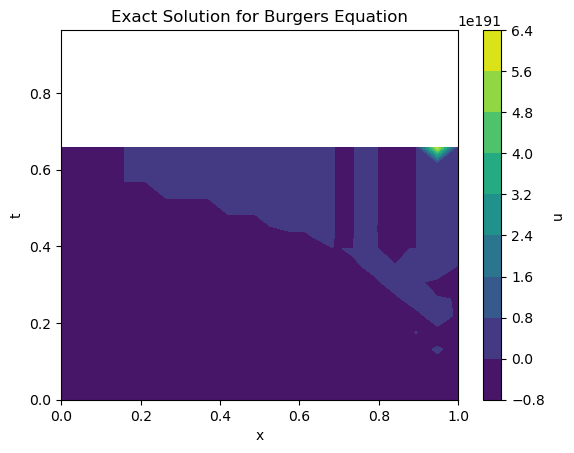

In [17]:
x = burger_1a.x
y = burger_1a.t
X , Y = np.meshgrid( x , y )

Z = burger_1a.u

contour = plt.contourf( X , Y , Z )

plt.title( "Exact Solution for Burgers Equation" )
plt.xlabel( "x" )
plt.ylabel( "t" )

cbar = plt.colorbar( contour )
cbar.set_label( "u" )

plt.show()


# Works Cited

1. Anderson, D. A., Tannehill, J. C., Pletcher, R. H., Munipalli, R., and Shankar, V. (2021). $ \underline{\text{Computational Fluid Mechanics and Heat Transfer}} $. 4th Edition. CRC Press.
